In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import math
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression

## List of all the stations and variables available in DBHydro portal

In [2]:
Station_list = ["POLESOUT", "KISSR0.0", "LZ2", "S133", "TCNS228", "S135",
                "FEBIN", "MBOXSOU", "MH24000", "FEBOUT", "L005", "L008", "LZ40", "L004", "S308C",
                "PALMOUNT", "S169", "S236", "POLE3S", "RITTAE2", "LZ2FA", "L007", "PELBAY3", "L006", "LZ30"]
Variable_list = ['NITRATE+NITRITE-N', 'NITRITE-N', 'AMMONIA-N', 'KJELDAHL NITROGEN, TOTAL', 'PHOSPHATE, ORTHO AS P',
                 'PHOSPHATE, TOTAL AS P', 'NITRATE-N', 'SILICA', 'CARBON, TOTAL ORGANIC', 'CARBON, DISSOLVED ORGANIC',
                 'TOTAL NITROGEN', 'PHOSPHATE, DISSOLVED AS P', 'KJELDAHL NITROGEN, DIS', 'CARBON, TOTAL', 
                 'CARBON, TOTAL INORGANIC', 'NITROGEN, TOTAL DISSOLVED', 'CHLOROPHYLL-A(LC)']

Others = ['CHLOROPHYLL-A', 'PHEOPHYTIN', 'CHLOROPHYLL-A, CORRECTED', 
         'CHLOROPHYLL-C', 'CAROTENOIDS', 'CHLOROPHYLL-B', 'CHLOROPHYLL-A(LC)', 
         'PHEOPHYTIN-A(LC)', 'CHLOROPHYLL-B(LC)', 'RESP. PLANKTONIC']

Nitrogen_list = ['NITRATE+NITRITE-N', 'NITRITE-N', 'AMMONIA-N', 'KJELDAHL NITROGEN, TOTAL',
                'TOTAL NITROGEN','NITRATE-N','KJELDAHL NITROGEN, DIS','NITROGEN, TOTAL DISSOLVED']
Phosphorus_list = ['PHOSPHATE, ORTHO AS P','PHOSPHATE, TOTAL AS P','PHOSPHATE, DISSOLVED AS P']
Carbon_list = ['CARBON, TOTAL ORGANIC', 'CARBON, DISSOLVED ORGANIC','CARBON, TOTAL','CARBON, TOTAL INORGANIC']

## The dictionary of predictors should use for each station:

In [3]:
summary = pd.read_csv("Variables_summary.csv")
Predictor_dict = dict({
    "POLESOUT":[],
    "KISSR0.0":[],
    "LZ2":[],
    "L005":[],
    "L008":[],
    "LZ40":[],
    "S308C":[],
    "POLE3S":[],
    "RITTAE2":[],
    "L007":[],
    "PELBAY3":[],
    "L006":[],
    "LZ30":[]
})

for station in list(Predictor_dict.keys()):
    station_summary = summary.loc[summary["Station"]==station, :]
    for variable in station_summary["Variable"]:
        if list(station_summary["Measurements in 2019"][station_summary["Variable"]==variable])[0] >= 10 and variable != 'CHLOROPHYLL-A(LC)' and variable not in Others:
            Predictor_dict[station].append(variable)

In [4]:
def Clean_date(df):
    """
    Transfer value in "Collection_Date" column in to Datetime object
    """
    for index, value in enumerate(df["Collection_Date"]):
        df["Collection_Date"][index] = datetime.strptime(value, '%Y-%m-%d %H:%M:%S')        
    return df

## Unit table of variables:

In [5]:
unit_dict = dict()
missing_var = []

for station in list(Predictor_dict.keys()):
    data = pd.read_csv(f"{station}.csv")
    for variable in Variable_list + ['CHLOROPHYLL-A, CORRECTED']:
        if variable not in unit_dict.keys():
            sub_data = data.loc[data["Test Name"]==variable,:]
            if len(sub_data) > 0:
                unit = list(sub_data["Units"])[0]
                unit_dict[variable] = unit
    if len(unit_dict) == len(Variable_list):
        break
        
unit_dict["FINAL CHLOROPHYLL-A"] = "ug/L"

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (17,18,26,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (9,14,15,18,25,27,31,32,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
pd.DataFrame({"Variable":list(unit_dict.keys()), "Unit":list(unit_dict.values())})

,Variable,Unit
0,NITRATE+NITRITE-N,mg/L
1,NITRITE-N,mg/L
2,AMMONIA-N,mg/L
3,"KJELDAHL NITROGEN, TOTAL",mg/L
4,"PHOSPHATE, ORTHO AS P",mg/L
5,"PHOSPHATE, TOTAL AS P",mg/L
6,NITRATE-N,mg/L
7,SILICA,mg/L
8,"CARBON, TOTAL ORGANIC",mg/L
9,"CARBON, DISSOLVED ORGANIC",mg/L


In [7]:
def Data_clean_up(data):
    """
    The columns of the final table:
    - Time (month-year)
    - Value of variable 1
    .
    .
    - Value of variable n
    """
    #clean date: 
    data = Clean_date(data)
    
    Time_array = []
    for year in range(2000, 2020):
        for month in range(1,13):
            Time_array.append(datetime(year, month, 1))
    
    clean_data = pd.DataFrame({"MonthYear": Time_array})
    
    global Variable_list
    for variable in Variable_list:
        Value_array = []
        for time in Time_array:
            #select rows based on the given date and variable:
            index_given_time = [True if (x.month == time.month and x.year == time.year) else False for x in data["Collection_Date"]]
            index_given_variable = data["Test Name"] == variable
            #combine 2 criteria:
            index_to_choose = index_given_time & index_given_variable
            
            values = data.loc[index_to_choose, "Value"]
            #Filter negative and NA values:
            values = [x for x in values if (not math.isnan(x)) and x >= 0]
         
            if len(values) > 0:
                Value_array.append(np.mean(values))
                
            else:
                Value_array.append(None)
                
        clean_data[variable] = Value_array
        
    return clean_data

In [8]:
def Data_clean_up_2(data):
    """
    Similar to Data_clean_up_2, only change the Variable_list
    """
    #clean date: 
    data = Clean_date(data)
    
    Time_array = []
    for year in range(2000, 2020):
        for month in range(1,13):
            Time_array.append(datetime(year, month, 1))
    
    clean_data = pd.DataFrame({"MonthYear": Time_array})
    
    Variable_list = ['NITRATE+NITRITE-N', 'NITRITE-N', 'AMMONIA-N', 'KJELDAHL NITROGEN, TOTAL', 'PHOSPHATE, ORTHO AS P',
                     'PHOSPHATE, TOTAL AS P', 'NITRATE-N', 'SILICA', 'CARBON, TOTAL ORGANIC', 'CARBON, DISSOLVED ORGANIC',
                     'TOTAL NITROGEN', 'PHOSPHATE, DISSOLVED AS P', 'KJELDAHL NITROGEN, DIS', 'CARBON, TOTAL', 
                     'CARBON, TOTAL INORGANIC', 'NITROGEN, TOTAL DISSOLVED', 'CHLOROPHYLL-A(LC)',
                     'CHLOROPHYLL-A', 'CHLOROPHYLL-A, CORRECTED',]
    for variable in Variable_list:
        Value_array = []
        for time in Time_array:
            #select rows based on the given date and variable:
            index_given_time = [True if (x.month == time.month and x.year == time.year) else False for x in data["Collection_Date"]]
            index_given_variable = data["Test Name"] == variable
            #combine 2 criteria:
            index_to_choose = index_given_time & index_given_variable
            
            values = data.loc[index_to_choose, "Value"]
            #Filter negative and NA values:
            values = [x for x in values if (not math.isnan(x)) and x >= 0]
         
            if len(values) > 0:
                Value_array.append(np.mean(values))
                
            else:
                Value_array.append(None)
                
        clean_data[variable] = Value_array
        
    return clean_data

In [9]:
station = "POLESOUT"
data = Data_clean_up(pd.read_csv(station+".csv"))
data

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,MonthYear,NITRATE+NITRITE-N,NITRITE-N,AMMONIA-N,"KJELDAHL NITROGEN, TOTAL","PHOSPHATE, ORTHO AS P","PHOSPHATE, TOTAL AS P",NITRATE-N,SILICA,"CARBON, TOTAL ORGANIC","CARBON, DISSOLVED ORGANIC",TOTAL NITROGEN,"PHOSPHATE, DISSOLVED AS P","KJELDAHL NITROGEN, DIS","CARBON, TOTAL","CARBON, TOTAL INORGANIC","NITROGEN, TOTAL DISSOLVED",CHLOROPHYLL-A(LC)
0,2000-01-01,0.324,NaN,0.010,0.999,0.046,0.116,NaN,NaN,None,NaN,NaN,None,None,None,None,None,NaN
1,2000-02-01,0.437,NaN,NaN,1.570,0.044,0.167,NaN,10.486,None,NaN,NaN,None,None,None,None,None,NaN
2,2000-03-01,0.301,NaN,NaN,1.218,0.046,0.130,NaN,NaN,None,NaN,NaN,None,None,None,None,None,NaN
3,2000-04-01,0.007,NaN,NaN,2.512,0.008,0.184,NaN,NaN,None,NaN,NaN,None,None,None,None,None,NaN
4,2000-05-01,0.351,0.004,NaN,1.398,0.020,0.116,0.347,11.242,None,NaN,NaN,None,None,None,None,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2019-08-01,NaN,NaN,0.014,NaN,NaN,0.048,NaN,4.060,None,NaN,2.15,None,None,None,None,None,74.7
236,2019-09-01,NaN,0.002,0.028,NaN,0.002,0.101,NaN,NaN,None,NaN,1.54,None,None,None,None,None,59.6
237,2019-10-01,NaN,0.002,0.019,NaN,0.010,0.152,NaN,NaN,None,NaN,1.82,None,None,None,None,None,28.9
238,2019-11-01,0.012,NaN,0.014,NaN,0.002,0.046,0.012,4.220,None,NaN,1.07,None,None,None,None,None,19.5


## Linear Regression for POLESOUT station

In [10]:
from sklearn.linear_model import LinearRegression

#Indentify indenpdent variables (predictors):
predictors = ["NITRATE+NITRITE-N", "NITRITE-N", "AMMONIA-N", "PHOSPHATE, TOTAL AS P"]
regression_table = pd.DataFrame({"Variable":predictors})

for station in ["POLESOUT", "KISSR0.0", "S308C", "LZ30"]:
    data = pd.read_csv(station+".csv")
    data = Data_clean_up(data)
    index_to_choose = [True for x in range(len(data))]
    #Identify the datapoints have NAs value to exclude (False value in index_to_choose)
    for variable in predictors + ["CHLOROPHYLL-A(LC)"]:
        for index, value in enumerate(data[variable]):
            if pd.isna(value):
                index_to_choose[index] = False

    X = data.loc[index_to_choose, predictors]
    y = data.loc[index_to_choose, "CHLOROPHYLL-A(LC)"]
    if len(X) > 20:
        regression = LinearRegression().fit(X,y)
        coefresult = regression.coef_

        regression_table[station] = coefresult

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (17,18,26,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (18,26,38) have mixed types. Specify 

In [11]:
regression_table

,Variable,POLESOUT,KISSR0.0,LZ30
0,NITRATE+NITRITE-N,-74.723657,-48.454017,-101.069967
1,NITRITE-N,-1365.592606,-34.038308,-21.353697
2,AMMONIA-N,-448.197635,-87.642632,-142.723360
3,"PHOSPHATE, TOTAL AS P",96.938254,58.982903,275.544136


In [12]:
station = "KISSR0.0"
data = Data_clean_up(pd.read_csv(station+".csv"))
data.describe()

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (17,18,26,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,NITRATE+NITRITE-N,NITRITE-N,AMMONIA-N,"KJELDAHL NITROGEN, TOTAL","PHOSPHATE, ORTHO AS P","PHOSPHATE, TOTAL AS P",NITRATE-N,SILICA,"CARBON, TOTAL ORGANIC","CARBON, DISSOLVED ORGANIC",TOTAL NITROGEN,CHLOROPHYLL-A(LC)
count,210.000000,189.000000,207.000000,166.000000,231.000000,233.000000,156.000000,77.000000,10.000000,17.000000,67.000000,109.000000
mean,0.117510,0.007907,0.048787,1.225012,0.040253,0.107270,0.116087,4.353004,9.285000,5.203176,1.293812,14.040924
std,0.129930,0.011101,0.057947,0.258911,0.032482,0.050439,0.114329,2.194890,6.407116,5.448680,0.241740,8.592089
min,0.004667,0.002000,0.005000,0.600000,0.002000,0.040333,0.005000,0.170000,1.000000,1.000000,0.899000,1.560000
25%,0.023750,0.004000,0.015000,1.054167,0.018625,0.074000,0.026250,2.850000,2.925000,1.100000,1.135000,7.403333
50%,0.067000,0.005500,0.029000,1.181667,0.032667,0.092000,0.067500,4.590000,9.500000,1.600000,1.260000,12.466667
75%,0.167958,0.008000,0.059000,1.340000,0.054000,0.126000,0.178000,5.706667,15.312500,7.666667,1.393333,18.400000
max,0.746000,0.128000,0.441000,2.650000,0.209000,0.292333,0.610000,9.840000,16.900000,16.333333,2.080000,49.600000


In [13]:
def count_num_points(data, station):
    global Predictor_dict
    num_points = pd.DataFrame()

    for number_of_remove in range(0, len(Predictor_dict[station])+1):
        combs = combinations(Predictor_dict[station], number_of_remove)
        for list_to_remove in list(combs):
            new_row = dict({i:True for i in Predictor_dict[station]})

            for remove_var in list_to_remove:
                new_row[remove_var] = False

            num_points = num_points.append(new_row, ignore_index=True)

    num_points['CHLOROPHYLL-A(LC)'] = [True for i in range(len(num_points))]
    num_data = []
    for i in range(len(num_points)):
        list_variable = []
        for variable in num_points.columns:
            if num_points[variable][i]:
                list_variable.append(variable)

        data2 = data.loc[:,list_variable]

        index_to_choose = [True for x in range(len(data2))]
        #Identify the datapoints have NAs value to exclude (False value in index_to_choose)
        data2.dropna(inplace=True)
#        for variable in data2.columns:
#            for index, value in enumerate(data2[variable]):
#                if pd.isna(value):
#                    index_to_choose[index] = False               
        num_data.append(len(data2))

    num_points["Num data"] = num_data
    return num_points.sort_values("Num data", ascending=False).reset_index(drop=True)

In [14]:
def FullLinearRegression(X,y):
    """
    Return the coefficients and cross validation score (leave one out)
    """
    regression = LinearRegression().fit(X,y)
    coeffs = regression.coef_

    cv_error = []

    for train_index, test_index in LeaveOneOut().split(X):
        X_train, X_test = X.iloc[np.array(train_index),:], X.iloc[np.array(test_index),:]
        y_train, y_test = y[train_index], y[test_index]
        regression = LinearRegression().fit(X_train, y_train)
        y_pred = regression.predict(X_test)
        cv_error.append(mean_squared_error(y_test, y_pred))
        
    return coeffs, cv_error

In [15]:
station = "POLESOUT"
data = Data_clean_up(pd.read_csv(f"{station}.csv"))
count_table = count_num_points(data, station)
count_table

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,AMMONIA-N,NITRATE+NITRITE-N,NITRATE-N,NITRITE-N,"PHOSPHATE, ORTHO AS P","PHOSPHATE, TOTAL AS P",TOTAL NITROGEN,CHLOROPHYLL-A(LC),Num data
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,109
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True,109
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,True,104
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,True,104
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,True,75
...,...,...,...,...,...,...,...,...,...
123,1.0,0.0,1.0,1.0,1.0,1.0,1.0,True,13
124,1.0,0.0,1.0,1.0,0.0,1.0,1.0,True,13
125,1.0,0.0,1.0,1.0,0.0,0.0,1.0,True,13
126,1.0,1.0,1.0,1.0,0.0,0.0,1.0,True,13


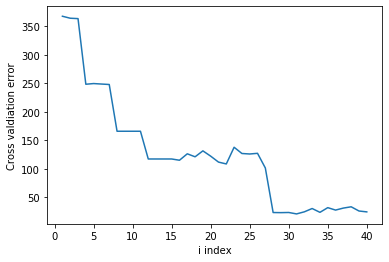

In [16]:
best_predictors = []
mean_error = []
for i in range(1,41):
    best_row = count_table.loc[[i],:]
    for predictor in Predictor_dict[station]:
        if best_row[predictor][i]:
            best_predictors.append(predictor)

    index_to_choose = [True for x in range(len(data))]
    #Identify the datapoints have NAs value to exclude (False value in index_to_choose)
    for variable in best_predictors + ["CHLOROPHYLL-A(LC)"]:
        for index, value in enumerate(data[variable]):
            if pd.isna(value):
                index_to_choose[index] = False

    X = data.loc[index_to_choose, best_predictors].reset_index(drop=True)
    y = data.loc[index_to_choose,"CHLOROPHYLL-A(LC)"].reset_index(drop=True)

    #regression_table = pd.DataFrame({"Predictor":best_predictors})
    cv_error = FullLinearRegression(X,y)[1]
    mean_error.append(np.mean(cv_error))
    
plt.plot(range(1,41), mean_error)
plt.xlabel("i index")
plt.ylabel("Cross valdiation error")
plt.show()

## Record the index of the best combination of predictor

In [17]:
Index_dict = dict()
for station in Predictor_dict.keys():
    data = Data_clean_up(pd.read_csv(f"{station}.csv"))
    count_table = count_num_points(data, station)
    
    best_predictors = []
    mean_error = []
    
    for i in range(1,len(count_table)):
        best_row = count_table.loc[[i],:]
        for predictor in Predictor_dict[station]:
            if best_row[predictor][i]:
                best_predictors.append(predictor)

        index_to_choose = [True for x in range(len(data))]
        #Identify the datapoints have NAs value to exclude (False value in index_to_choose)
        for variable in best_predictors + ["CHLOROPHYLL-A(LC)"]:
            for index, value in enumerate(data[variable]):
                if pd.isna(value):
                    index_to_choose[index] = False

        X = data.loc[index_to_choose, best_predictors].reset_index(drop=True)
        y = data.loc[index_to_choose,"CHLOROPHYLL-A(LC)"].reset_index(drop=True)

        cv_error = FullLinearRegression(X,y)[1]
        mean_error.append(np.mean(cv_error))
        
    Index_dict[station] = mean_error

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (17,18,26,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [18]:
Index_dict

{'POLESOUT': [367.41186876735594,
  363.9429171958344,
  363.2585825388977,
  248.27912053339062,
  249.46717164450666,
  248.6159116979376,
  247.83417940660948,
  165.90974245389208,
  165.90974245389205,
  165.90974245389177,
  165.90974245389205,
  117.31539601652455,
  117.31539601652453,
  117.31539601652472,
  117.31539601652426,
  115.10977373873413,
  126.38552288819184,
  121.1495426077013,
  131.53051687741046,
  122.24160462202474,
  111.8499676308907,
  108.61740964263603,
  137.86105364385742,
  126.92515743833347,
  126.06401704211629,
  127.22561768475519,
  101.57097427077679,
  23.49549445225906,
  23.298897349515574,
  23.57890147909141,
  21.06463298818314,
  24.730860491238822,
  30.518850988456485,
  23.840456367340952,
  32.04564015478599,
  27.783166951838286,
  31.290395491052628,
  33.54178073323414,
  26.17373856418745,
  24.62610823936918,
  33.10972764045251,
  25.70723651469178,
  36.64453580754297,
  25.236003766315854,
  24.427623488599888,
  24.65888097

In [19]:
LN_result = dict()
for station in Predictor_dict.keys():
    data = Data_clean_up(pd.read_csv(f"{station}.csv"))
    count_table = count_num_points(data, station)
    
    i = Index_dict[station].index(min(Index_dict[station]))
    best_row = count_table.loc[[i],:]
    best_predictors = []
    for predictor in Predictor_dict[station]:
        if best_row[predictor][i]:
            best_predictors.append(predictor)

    #Drop NAs values
    data.dropna(subset=best_predictors+["CHLOROPHYLL-A(LC)"], inplace=True)

    X = data[best_predictors].reset_index(drop=True)
    y = data["CHLOROPHYLL-A(LC)"].reset_index(drop=True)

    coefs, cv_error = FullLinearRegression(X,y)
    LN_result[station] = [best_predictors, coefs, np.mean(cv_error)]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (17,18,26,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [20]:
LN_result.keys()

dict_keys(['POLESOUT', 'KISSR0.0', 'LZ2', 'L005', 'L008', 'LZ40', 'S308C', 'POLE3S', 'RITTAE2', 'L007', 'PELBAY3', 'L006', 'LZ30'])

In [21]:
reg_table = pd.DataFrame({"Station": list(LN_result.keys()),
             "Predictors": [value[0] for value in LN_result.values()],
             "Coefficients": [np.round(value[1],2) for value in LN_result.values()],
             "Mean Squared Error": [value[2] for value in LN_result.values()]})
reg_table.to_csv("LinearReg.csv", index=False)

In [22]:
for station in LN_result.keys():
    print(pd.DataFrame({"Predictor":LN_result[station][0], "Coefficients":LN_result[station][1]}))
    print(f"Station: {station}, CV error: {LN_result[station][2]}")
    print("--")

               Predictor  Coefficients
0  PHOSPHATE, ORTHO AS P    -38.783958
1              NITRATE-N    -29.804661
Station: POLESOUT, CV error: 75.01475051209812
--
           Predictor  Coefficients
0  NITRATE+NITRITE-N   -131.634057
1          AMMONIA-N    -53.453460
2          NITRATE-N     87.031389
Station: KISSR0.0, CV error: 62.48001987390473
--
               Predictor  Coefficients
0      NITRATE+NITRITE-N    -61.915613
1              AMMONIA-N    -81.587196
2  PHOSPHATE, TOTAL AS P     95.797733
Station: LZ2, CV error: 139.05819093720524
--
        Predictor  Coefficients
0       NITRITE-N   -745.758108
1  TOTAL NITROGEN      5.214117
Station: L005, CV error: 240.87528191065482
--
               Predictor  Coefficients
0              AMMONIA-N    216.211857
1  PHOSPHATE, ORTHO AS P   -225.573286
2  PHOSPHATE, TOTAL AS P     -6.550008
Station: L008, CV error: 133.24152318507132
--
               Predictor  Coefficients
0              NITRITE-N    -38.939567
1  PHOSPHATE, TOT

In [23]:
def Data_clean_up_3(data, monthly_average=True):
    """
    Similar to Data_clean_up_1, only change the Variable_list 
    and combining the chlorophyll-A (corrected) with chlorophyll-A (LC)
    """

    #clean date: 
    data = Clean_date(data)
    Variable_list = ['NITRATE+NITRITE-N', 'NITRITE-N', 'AMMONIA-N', 'KJELDAHL NITROGEN, TOTAL', 'PHOSPHATE, ORTHO AS P',
                 'PHOSPHATE, TOTAL AS P', 'NITRATE-N', 'SILICA', 'CARBON, TOTAL ORGANIC', 'CARBON, DISSOLVED ORGANIC',
                 'TOTAL NITROGEN', 'PHOSPHATE, DISSOLVED AS P', 'KJELDAHL NITROGEN, DIS', 'CARBON, TOTAL', 
                 'CARBON, TOTAL INORGANIC', 'NITROGEN, TOTAL DISSOLVED', 'CHLOROPHYLL-A(LC)',
                 'CHLOROPHYLL-A', 'CHLOROPHYLL-A, CORRECTED']
    if monthly_average:
        Time_array = []
        for year in range(2000, 2020):
            for month in range(1,13):
                Time_array.append(datetime(year, month, 1))

        clean_data = pd.DataFrame({"MonthYear": Time_array})

        for variable in Variable_list:
            Value_array = []
            for time in Time_array:
                #select rows based on the given date and variable:
                index_given_time = [True if (x.month == time.month and x.year == time.year) else False for x in data["Collection_Date"]]
                index_given_variable = data["Test Name"] == variable
                #combine 2 criteria:
                index_to_choose = index_given_time & index_given_variable

                values = data.loc[index_to_choose, "Value"]
                #Filter negative and NA values:
                values = [x for x in values if (not math.isnan(x)) and x >= 0]

                if len(values) > 0:
                    Value_array.append(np.mean(values))

                else:
                    Value_array.append(None)

            clean_data[variable] = Value_array
        clean_data.fillna(value=np.nan,inplace=True)
        
    else:
        group_data = []
        for variable in Variable_list:
            #select rows based on the given date and variable:
            index_given_variable = data["Test Name"] == variable
            values = data.loc[index_given_variable, ["Collection_Date", "Value"]]
            #Filter negative and NA values:
            values.dropna(inplace=True)
            values = values.loc[values["Value"]>=0]
            values = values.rename(columns={"Value":variable})
            group_data.append(values)
        #clean_data = pd.concat(group_data)
        clean_data = group_data[0]
        for data in group_data[1:]:
            clean_data = clean_data.merge(data, on=["Collection_Date"], how='left')
        
    if sum(list(clean_data[['CHLOROPHYLL-A(LC)', 'CHLOROPHYLL-A, CORRECTED']].describe().loc["count",:])) != 0:
        clean_data["FINAL CHLOROPHYLL-A"] = np.nanmean(clean_data[['CHLOROPHYLL-A(LC)', 'CHLOROPHYLL-A, CORRECTED']], axis=1)
    return clean_data

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice


<Figure size 432x288 with 0 Axes>

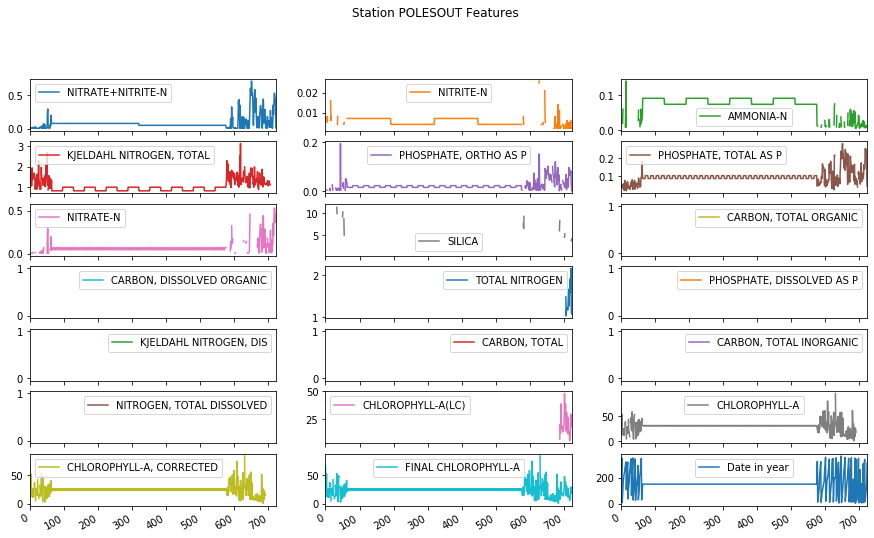

In [25]:
station = "POLESOUT"
data = Data_clean_up_3(pd.read_csv(f"{station}.csv"), monthly_average=False)
data["Date in year"] = list(map(lambda date: date.timetuple().tm_yday,
                                data["Collection_Date"]))
plt.figure()
data.drop(columns=["Collection_Date"]).plot(subplots=True, layout=(8, 3), figsize=(15, 10), title=f'Station {station} Features')
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice


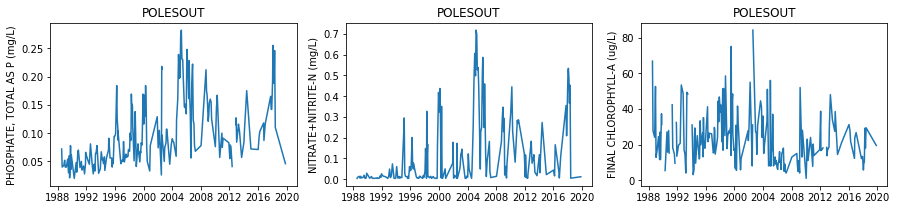

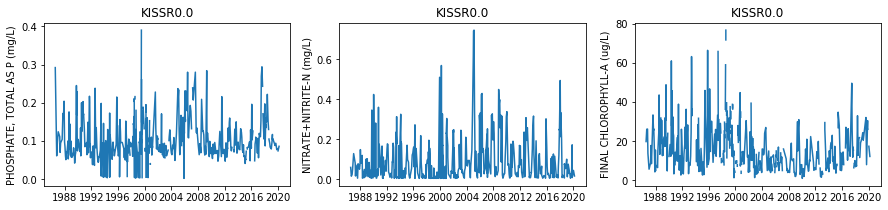

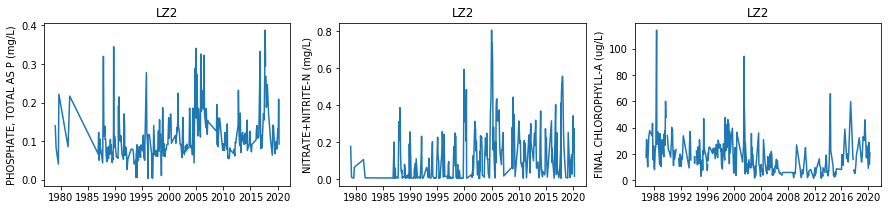

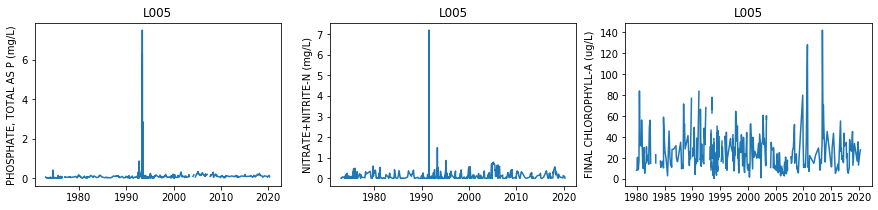

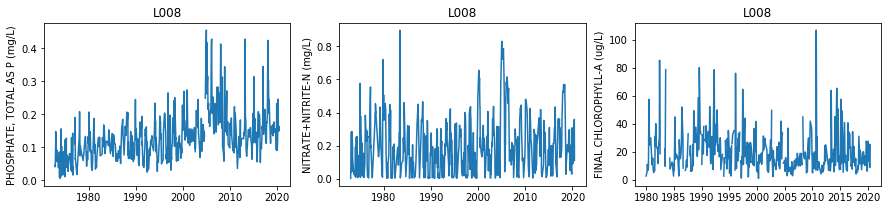

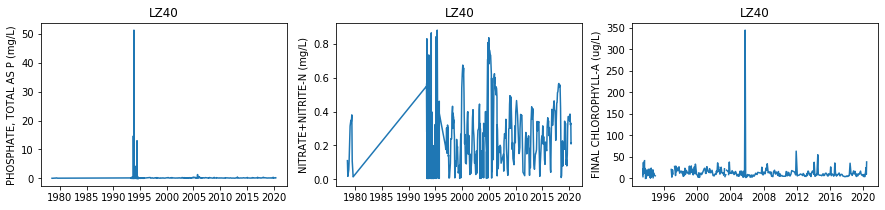

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (18,26,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


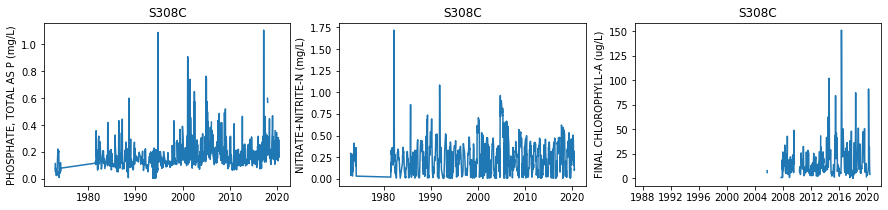

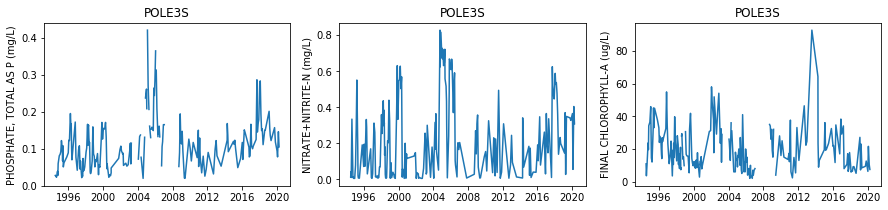

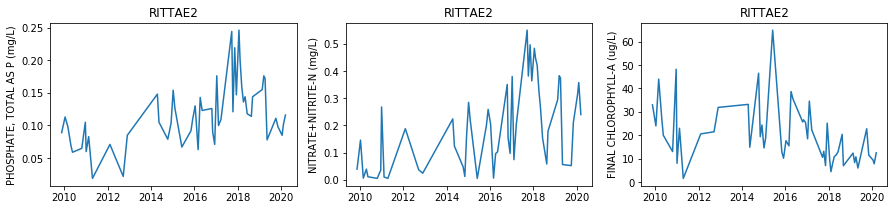

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (9,17,18,26,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


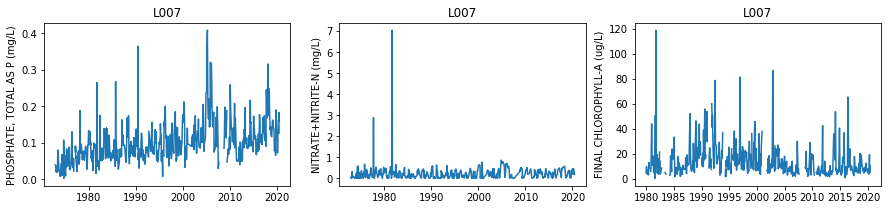

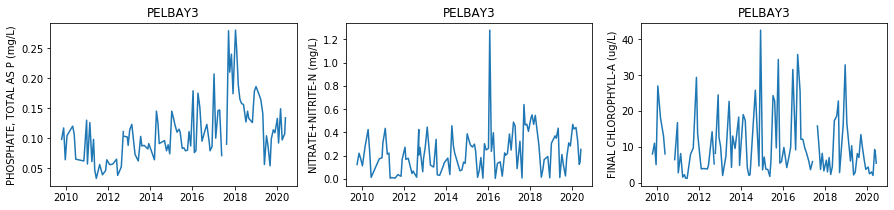

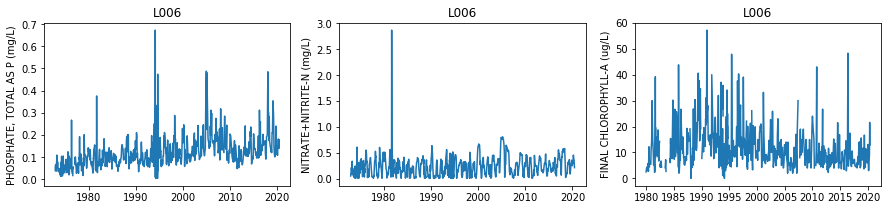

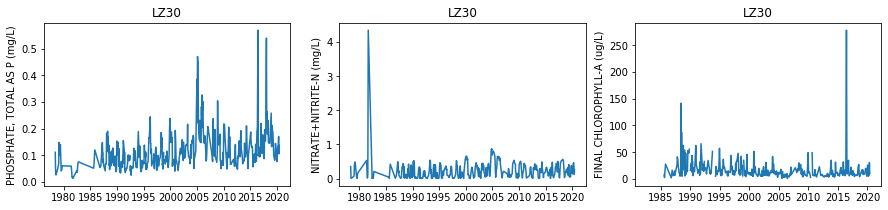

In [26]:
for station in Predictor_dict.keys():
    data = Data_clean_up_3(pd.read_csv(f"{station}.csv"), monthly_average=False).sort_values(by='Collection_Date', ascending=True)
    fig = plt.figure(figsize=(15,3))
    i = 0
    for variable in ["PHOSPHATE, TOTAL AS P", "NITRATE+NITRITE-N", "FINAL CHLOROPHYLL-A"]:
        i += 1
        ax = fig.add_subplot(1, 3, i)
        ax.plot(data["Collection_Date"], data[variable])
        ax.set_ylabel(f"{variable} ({unit_dict[variable]})")
        ax.set_title(station)
    plt.show()

In [27]:
LN_result_2 = dict()

for station in Predictor_dict.keys():
    data = Data_clean_up_3(pd.read_csv(f"{station}.csv"), monthly_average=False)
    data = data.loc[:,["PHOSPHATE, TOTAL AS P", "NITRATE+NITRITE-N", "FINAL CHLOROPHYLL-A"]].dropna()
    if len(data) > 100:
        X = data[["PHOSPHATE, TOTAL AS P", "NITRATE+NITRITE-N"]].reset_index(drop=True)
        y = data["FINAL CHLOROPHYLL-A"].reset_index(drop=True)
        regression = LinearRegression().fit(X,y)
        LN_result_2[station] = [list(X.columns), regression.coef_, regression.score(X,y)]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (17,18,26,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-pa

In [28]:
for station in LN_result_2.keys():
    print(pd.DataFrame({"Predictor":LN_result_2[station][0], "Coefficients":LN_result_2[station][1]}))
    print(f"Station: {station}, Score: {LN_result_2[station][2]}")
    print("--")

               Predictor  Coefficients
0  PHOSPHATE, TOTAL AS P     66.207387
1      NITRATE+NITRITE-N    -45.942008
Station: POLESOUT, Score: 0.13821740994591314
--
               Predictor  Coefficients
0  PHOSPHATE, TOTAL AS P     -9.002952
1      NITRATE+NITRITE-N     15.238926
Station: KISSR0.0, Score: 0.031830812255927876
--
               Predictor  Coefficients
0  PHOSPHATE, TOTAL AS P      3.767837
1      NITRATE+NITRITE-N    -37.659347
Station: LZ2, Score: 0.2926687960456751
--
               Predictor  Coefficients
0  PHOSPHATE, TOTAL AS P     -9.901821
1      NITRATE+NITRITE-N    -20.950846
Station: L005, Score: 0.3679133665523523
--
               Predictor  Coefficients
0  PHOSPHATE, TOTAL AS P   -320.479517
1      NITRATE+NITRITE-N   -109.286026
Station: L008, Score: 0.7191471535036973
--
               Predictor  Coefficients
0  PHOSPHATE, TOTAL AS P     16.710396
1      NITRATE+NITRITE-N     -8.437519
Station: LZ40, Score: 0.040659274921366007
--
               Predict

In [29]:
LG_result_2 = dict()
threshold = 40
for station in Predictor_dict.keys():
    data = Data_clean_up_3(pd.read_csv(f"{station}.csv"), monthly_average=False)
    data = data.loc[:,["PHOSPHATE, TOTAL AS P", "NITRATE+NITRITE-N", "FINAL CHLOROPHYLL-A"]].dropna()
    if len(data) > 100:
        X = data[["PHOSPHATE, TOTAL AS P", "NITRATE+NITRITE-N"]].reset_index(drop=True)
        y = data["FINAL CHLOROPHYLL-A"].reset_index(drop=True) > threshold
        regression = LogisticRegression().fit(X,y)
        LG_result_2[station] = [list(X.columns), regression.coef_, regression.score(X,y)]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (17,18,26,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Correct the error: 

In [30]:
LN_result_3 = dict()
M = 3350 #The molar mass of the result
for station in Predictor_dict.keys():
    data = Data_clean_up_3(pd.read_csv(f"{station}.csv"), monthly_average=False)
    data = data.loc[:,["PHOSPHATE, TOTAL AS P", "NITRATE+NITRITE-N", "FINAL CHLOROPHYLL-A"]].dropna()
    if len(data) > 100:
        data["Next chlA"] = [None] + list(data["FINAL CHLOROPHYLL-A"])[:-1]
        data.dropna(inplace=True)
        data["Difference"] = data["Next chlA"] - data["FINAL CHLOROPHYLL-A"]
        data["Increase"] = [x if x > 0 else 0 for x in list(data["Difference"])]
        data["PHOSPHATE, TOTAL AS P"] = data["PHOSPHATE, TOTAL AS P"]+data["Increase"]*10**(-3)/M*95
        data["NITRATE+NITRITE-N"] =  data["NITRATE+NITRITE-N"]+data["Increase"]*10**(-3)/M*62
        X = data[["PHOSPHATE, TOTAL AS P", "NITRATE+NITRITE-N"]].reset_index(drop=True)
        y = data["FINAL CHLOROPHYLL-A"].reset_index(drop=True)
        regression = LinearRegression().fit(X,y)
        LN_result_3[station] = [list(X.columns), regression.coef_, regression.score(X,y)]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (17,18,26,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-pa

In [31]:
for station in LN_result_3.keys():
    print(pd.DataFrame({"Predictor":LN_result_3[station][0], "Coefficients":LN_result_3[station][1]}))
    print(f"Station: {station}, Score: {LN_result_3[station][2]}")
    print("--")

               Predictor  Coefficients
0  PHOSPHATE, TOTAL AS P     66.263833
1      NITRATE+NITRITE-N    -45.483372
Station: POLESOUT, Score: 0.1402168462967025
--
               Predictor  Coefficients
0  PHOSPHATE, TOTAL AS P     -9.002012
1      NITRATE+NITRITE-N     15.233601
Station: KISSR0.0, Score: 0.03180516943151468
--
               Predictor  Coefficients
0  PHOSPHATE, TOTAL AS P      3.672971
1      NITRATE+NITRITE-N    -37.720528
Station: LZ2, Score: 0.2933695217993474
--
               Predictor  Coefficients
0  PHOSPHATE, TOTAL AS P     -9.993585
1      NITRATE+NITRITE-N    -20.950574
Station: L005, Score: 0.36817427324530105
--
               Predictor  Coefficients
0  PHOSPHATE, TOTAL AS P   -326.492221
1      NITRATE+NITRITE-N   -108.623981
Station: L008, Score: 0.7215017662996034
--
               Predictor  Coefficients
0  PHOSPHATE, TOTAL AS P     16.590543
1      NITRATE+NITRITE-N     -8.438537
Station: LZ40, Score: 0.04052072131465023
--
               Predictor

In [32]:
score_2 = [x[2] for x in LN_result_2.values()]
score_3 = [x[2] for x in LN_result_3.values()]
np.array(score_3) - np.array(score_2)

array([ 1.99943635e-03, -2.56428244e-05,  7.00725754e-04,  2.60906693e-04,
        2.35461280e-03, -1.38553607e-04,  4.79992399e-04,  8.17210763e-04,
       -6.06811128e-06,  1.97272413e-03,  5.82742933e-05,  1.91043331e-04])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice


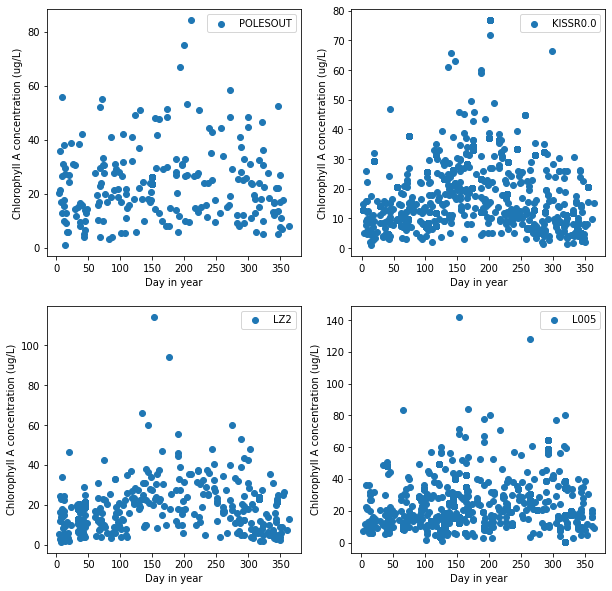

In [47]:
fig = plt.figure(figsize=(10,10))
i = 0 
for station in ["POLESOUT", "KISSR0.0", "LZ2", "L005"]:
    data = Data_clean_up_3(pd.read_csv(f"{station}.csv"), monthly_average=False)
    data["Date in year"] = list(map(lambda date: date.timetuple().tm_yday,
                                data["Collection_Date"]))
    i += 1
    ax = fig.add_subplot(2, 2, i)
    ax.scatter(data["Date in year"], data["FINAL CHLOROPHYLL-A"], label=station)
    ax.set_ylabel("Chlorophyll A concentration (ug/L)")
    ax.set_xlabel("Day in year")
    ax.legend()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (26,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


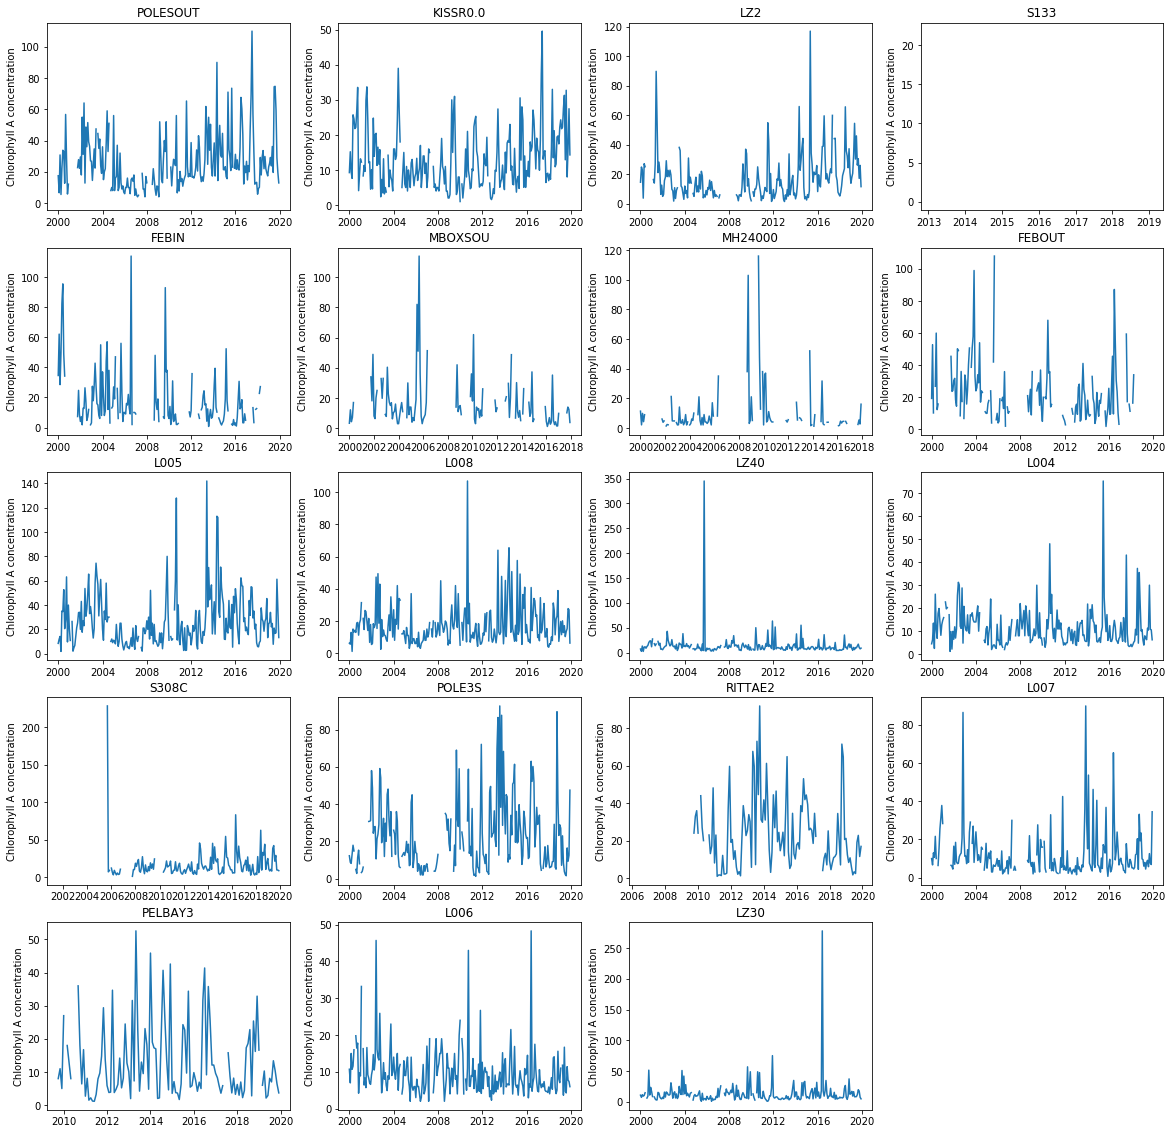

In [34]:
fig = plt.figure(figsize=(20,20))
i=0
for station in Station_list:
    data = Data_clean_up_3(pd.read_csv(f"{station}.csv"))
    if 'FINAL CHLOROPHYLL-A' in data.columns:
        i += 1
        ax = fig.add_subplot(5, 4, i)
        ax.plot(data["MonthYear"], data["FINAL CHLOROPHYLL-A"])
        ax.set_ylabel("Chlorophyll A concentration")
        ax.set_title(station)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice


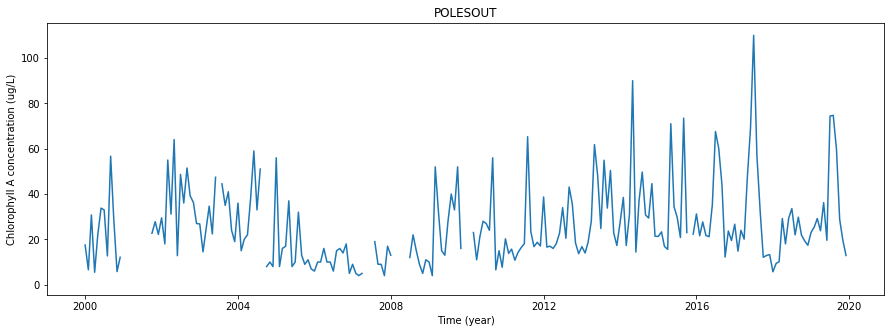

In [36]:
station = "POLESOUT"
data = Data_clean_up_3(pd.read_csv(f"{station}.csv"))
plt.figure(figsize=(15,5))
plt.plot(data["MonthYear"], data["FINAL CHLOROPHYLL-A"])
plt.ylabel("Chlorophyll A concentration (ug/L)")
plt.xlabel("Time (year)")
plt.title(station)
plt.show()